# 把自己寫的兩個gaussian改成一個gaussian

source: "C:\Users\user\OneDrive - 國立陽明交通大學\桌面\001__1141碩士生存指南\0003_Diffusion Model 研究相關_得勝\2025Autumn_ML-project-DiffusionModel_02\20251113_code\03_SDEs_forwardBackwardODE.ipynb"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
beta=0.7
sigma=1.0
T=10.0
t_target=3.0
dt=5e-3  #時間步長

#w=0.55  #mixture
mu1=8.0
s1=1.1
#mu2=2.0
#s2=0.9

K_traj=32  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

In [18]:
def sample_gmm(n, mu1, s1,rng):
    z1 = rng.normal(mu1, s1, size=n)
    return z1

def m_t(t, mu): 
    return np.exp(-beta*t)*mu

def v_t(t, s): 
    return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))

def gmm_pdf(y, mu1, s1):   #初始時間的pdf
    n1 = (1.0/np.sqrt(2*np.pi*s1**2))*np.exp(-0.5*((y-mu1)/s1)**2)
    return n1

def gmm_ou_pdf(y, t):                  #經過OU process之後的mixture pdf
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((y-m1)**2)/v1)
    return n1

def gmm_ou_score(x, t):                #反向SDE會用到
    """∇_x log p_t(x) for OU-evolved Gaussian mixture."""
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    # component pdf
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((x-m1)**2)/v1)
    denom = n1
    r1 = n1/denom     # responsibility for comp1
    s1x = -(x - m1)/v1
    return r1*s1x

In [19]:
### 畫圖

def plot(traj_hist, times, t_target, mu1, s1):
        # ---- plotting ----
    fig = plt.figure(figsize=(11,2.2))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
    ax_left  = fig.add_subplot(gs[0,0])
    ax_main  = fig.add_subplot(gs[0,1])
    ax_right = fig.add_subplot(gs[0,2])

    for j in range(traj_hist.shape[1]):
        ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
    #ax_main.set_title(mode.replace("_", " ").title())
    ax_main.set_xlabel("$t$")

    ymin = np.min(traj_hist); ymax = np.max(traj_hist)
    pad = 0.2*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(*ylims)
    ys = np.linspace(*ylims, 700)

    ax_left.plot(gmm_pdf(ys, mu1, s1), ys, color="C0", linewidth=2)
    ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

    ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
    ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

    pdf_mid = gmm_ou_pdf(ys, t_target)
    scale = 0.25
    pdf_mid_norm = pdf_mid / pdf_mid.max()
    ax_main.plot(t_target + scale*pdf_mid_norm, ys, color="C0", linewidth=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)
    plt.show()


# 1. Forward SDE (OU process)

In [20]:
def SDE_forward(beta, sigma, rng,
                  T, t_target, dt,
                  mu1, s1,
                  K_traj, N_part):
    steps = int(T/dt)
    x = sample_gmm(N_part, mu1, s1, rng)
    times = [0.0]
    traj_hist = [x[:K_traj].copy()]
    t = 0.0
    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        x = x + (-beta*x)*dt + sigma*dW
        t += dt
        if i % int(steps/300) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    plot(traj_hist, times, t_target, mu1, s1)

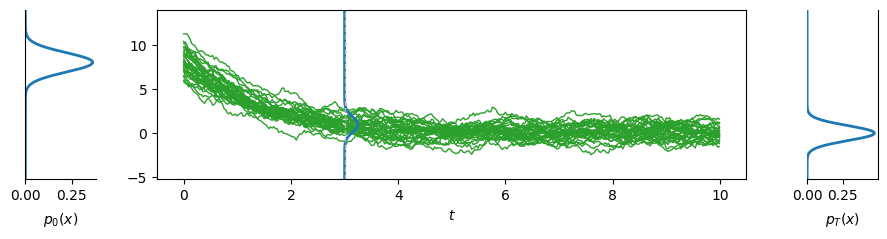

In [21]:
SDE_forward(beta, sigma, rng,
                  T, t_target, dt,
                  mu1, s1,
                  K_traj, N_part)

# 2. Backward SDE(OU process)

In [24]:
# At t=T
mean_T = np.exp(-beta*T)*mu1
sigma_T_square = np.exp(-2.0*beta*T)*(s1**2)+ (1-np.exp(-2.0*beta*T))*(sigma**2)/(2.0*beta)
sigma_T = np.sqrt(sigma_T_square)
mean_inf = 0.0
sigma_inf = np.sqrt(sigma**2/(2.0*beta))

In [ ]:
def simulate_backward_OU(beta, sigma, T, dt,
                         mu1, s1,
                         N_part, K_traj, seed):
    rng = np.random.default_rng(seed)
    steps = int(T/dt)
 
    m1_T, v1_T = m_t(T, mu1), v_t(T, s1)
    x1 = rng.normal(m1_T, np.sqrt(v1_T), size=N_part)
    x  = x1

    times = [0.0]                 
    traj_hist = [x[:K_traj].copy()]
    
    t=T
    
    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        m1_t, v1_t = m_t(t, mu1), v_t(t, s1)
        mt = m1_t
        vt = v1_t
        drift = (-beta*x + (sigma**2)*(x - mt)/vt)
        x = x + drift*(-dt) + sigma*dW
        t += (-1)*dt

        if i % int(steps/300) == 0:
            current_t = T - i*dt
            times.append(current_t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)
    times = times[::-1]
    traj_hist = traj_hist[::-1, :]

    # 確保 times 從小到大
    idx = np.argsort(times)

    plot(traj_hist, times, t_target, mu1, s1)


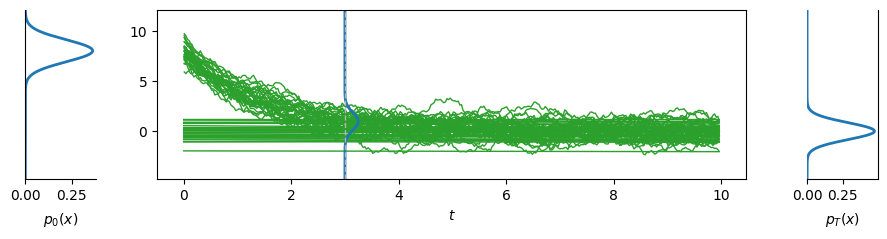

In [23]:
simulate_backward_OU(beta, sigma, T, dt,
                        mu1, s1,
                         N_part, K_traj, seed)

## 2.2

In [29]:
def SDE_reverse(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part):

    steps = int(T/dt)
    
    # At t=T
    mean_T = np.exp(-beta*T)*mu1
    sigma_T_square = np.exp(-2.0*beta*T)*(s1**2)+ (1-np.exp(-2.0*beta*T))*(sigma**2)/(2.0*beta)
    sigma_T = np.sqrt(sigma_T_square)
    mean_inf = 0.0
    sigma_inf = np.sqrt(sigma**2/(2.0*beta))

    # 初始點：從 p_T 取樣（使用 OU 的 analytic distribution）
    # 若你想用 forward 的最終值，也可以把那個 x_T 傳進來
#    mT = m_t(T, mu1)
#    vT = v_t(T, s1)
    x = rng.normal(mean_T, sigma_T, size=N_part)

    times = [T]
    traj_hist = [x[:K_traj].copy()]

    t = T
    for i in range(1, steps+1):

        # reverse-time步長：往回走
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)

        # score term: ∇_x log p_{t}(x)
        score = gmm_ou_score(x, t)

        # Anderson / Song reverse SDE drift
        drift = -beta*x - sigma**2 * score

        # Euler–Maruyama backward
        x = x + drift*dt + sigma*dW

        t -= dt

        if i % int(steps/300) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

# 時間 0 → T
    times = np.array(times)
    traj_hist = np.stack(traj_hist)

    idx = np.argsort(times)
    times = times[idx]
    traj_hist = traj_hist[idx]

    plot(traj_hist, times, t_target, mu1, s1)

C:\Users\user\AppData\Local\Temp\ipykernel_980\3800564498.py:26: RuntimeWarning: invalid value encountered in divide
  r1 = n1/denom     # responsibility for comp1


ValueError: Axis limits cannot be NaN or Inf

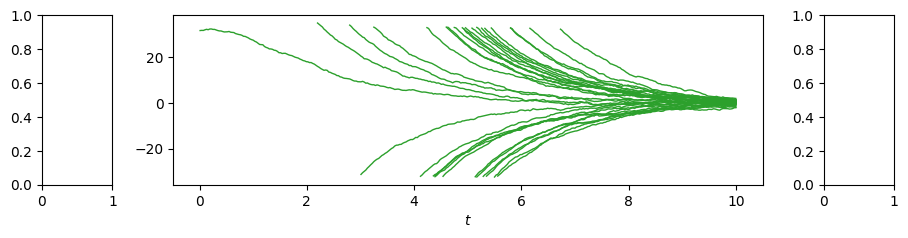

In [30]:
SDE_reverse(beta, sigma, rng,
                T, t_target, dt,
                mu1, s1,
                K_traj, N_part)